In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.basemap import Basemap
plt.rcParams["figure.figsize"] = (25,12)

# Data Processing

## Routes Dataset

<Big> <u>Flights Data</u></Big>

As of June 2014, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe, as shown in the map above. Each entry contains the following information:
- **Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.
- **Airline ID**	Unique OpenFlights identifier for airline (see Airline).
- **Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
- **Source airport ID**	Unique OpenFlights identifier for source airport (see Airport)
- **Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
- **Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)
- **Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
- **Stops**	Number of stops on this flight ("0" for direct)
- **Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces<br>
The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.<br>
**Notes**:
- Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
- Routes where one carrier operates both its own and codeshare flights are listed only once.

We start by reading the csv and removing unnecessary columns (Airline, AirlineID, Source Airport ID, Destination Airport ID, Codeshare, Stops, Equipment). After that we renamed the columns of interest to 'origin' and 'destination'.

In [3]:
routes = pd.read_csv('routes.csv', sep=',', header=None)
routes = routes.drop([0,1,3,5,6,7,8], axis=1)

In [4]:
routes.rename(columns={2:'origin', 4:'destination'}, inplace=True)
routes

,origin,destination
0,AER,KZN
1,ASF,KZN
2,ASF,MRV
3,CEK,KZN
4,CEK,OVB
...,...,...
67658,WYA,ADL
67659,DME,FRU
67660,FRU,DME
67661,FRU,OSS


Removing isolated nodes

In [5]:
isolated = ['BMY', 'GEA', 'ILP', 'KNQ', 'KOC', 'LIF', 'MEE', 'TGJ', 'TOU', 'UVE','ERS', 'MPA', 'NDU', 'OND','BFI', 'CLM', 'ESD', 'FRD','AKB', 'DUT', 'IKO', 'KQA','SPB', 'SSB','CKX', 'TKJ','BLD', 'GCW', 'ACU',
'AWD', 'FTA', 'AXR', 'KKR', 'RFP', 'MAU', 'XMH', 'RGI', 'BOB', 'TIH', 'MVT', 'HUH', 'FAV', 'MOZ', 'MKP', 'HOI', 'GMR', 'NHV', 'UAP', 'UAH', 'TUB', 'RUR', 'TKP', 'TKX']

In [6]:
routes = routes[np.logical_not(routes.origin.isin(isolated))]
routes = routes[np.logical_not(routes.destination.isin(isolated))]

## Global Airport Database

The website from which we retrieved the flights dataset also had an airport database with IATA codes, however this database contained a lot of NA's so we found another database from [here](https://www.partow.net/miscellaneous/airportdatabase/)

|Name|Type|
|----|----|
|ICAO|Code|String (3-4 chars, A - Z)
|IATA|Code|String (3 chars, A - Z)
|Airport Name|String
|City/Town|	String
|Country|String
|Latitude Degrees|Integer [0,360]
|Latitude Minutes|Integer [0,60]
|Latitude Seconds|Integer [0,60]
|Latitude Direction|Char (N or S)
|Longitude Degrees|Integer [0,360]
|Longitude Minutes|Integer [0,60]
|Longitude Seconds|Integer [0,60]
|Longitude Direction|Char (E or W)
|Altitude|Integer [-99999,+99999] (Altitude in meters from mean sea level)
|Latitude Decimal Degrees|Floating point [-90,90]
|Longitude Decimal Degrees|Floating point [-180,180]

In [7]:
airports = pd.read_csv('GlobalAirportDatabase/GlobalAirportDatabase.txt', delimiter=':', header=None)
airports = airports.drop([0,2,5,6,7,8,9,10,11,12,13], axis=1)

In [8]:
airports = airports.rename({1:'iata', 3:'city', 4:'country', 14:'lat', 15:'long'}, axis=1)

In [9]:
# Remove IATA null values
airports = airports[~airports['iata'].isna()]
airports

,iata,city,country,lat,long
0,GKA,GOROKA,PAPUA NEW GUINEA,-6.082,145.392
1,LAE,LAE,PAPUA NEW GUINEA,0.000,0.000
2,MAG,MADANG,PAPUA NEW GUINEA,-5.207,145.789
3,HGU,MOUNT HAGEN,PAPUA NEW GUINEA,-5.826,144.296
4,LAE,NADZAB,PAPUA NEW GUINEA,-6.570,146.726
...,...,...,...,...,...
9276,HTN,HOTAN,CHINA,37.038,79.866
9278,URC,URUMQI,CHINA,43.907,87.474
9286,HRB,HARBIN,CHINA,45.623,126.250
9293,CGQ,CHANGCHUN,CHINA,0.000,0.000


## Routes dataset with only the values present in airports database

In [10]:
# routes[routes['origin'].isin(airports[1])]
routes = routes[(routes['origin'].isin(airports['iata'])) & routes['destination'].isin(airports['iata'])]
routes

,origin,destination
0,AER,KZN
1,ASF,KZN
2,ASF,MRV
3,CEK,KZN
4,CEK,OVB
...,...,...
67652,TSV,ISA
67654,WGA,MEL
67655,WGA,SYD
67661,FRU,OSS


## Group by [origin-destination]

In [11]:
origin_unique = np.unique(routes.origin)
dest_unique = np.unique(routes.destination)
nodes = np.unique(np.concatenate([origin_unique, dest_unique], axis=0))
# nodes
len(nodes)

2107

In [12]:
routes_weight = routes.groupby(['origin', 'destination']).size()
routes_weight

origin  destination
AAE     ALG            1
        CDG            1
        IST            1
        LYS            1
        MRS            2
                      ..
ZTH     VIE            2
ZVK     BKK            1
        PKZ            1
        VTE            1
ZYL     DAC            4
Length: 28725, dtype: int64

In [13]:
links = routes_weight.index.unique()
weights = routes_weight.tolist()
weight_input = [link + (weigth,)  for link, weigth in zip(links, weights)]
weight_input

[('AAE', 'ALG', 1),
 ('AAE', 'CDG', 1),
 ('AAE', 'IST', 1),
 ('AAE', 'LYS', 1),
 ('AAE', 'MRS', 2),
 ('AAE', 'ORN', 1),
 ('AAE', 'ORY', 2),
 ('AAL', 'AAR', 1),
 ('AAL', 'AGP', 1),
 ('AAL', 'ALC', 1),
 ('AAL', 'AMS', 2),
 ('AAL', 'ARN', 1),
 ('AAL', 'BCN', 2),
 ('AAL', 'BLL', 3),
 ('AAL', 'CPH', 2),
 ('AAL', 'IST', 1),
 ('AAL', 'LGW', 1),
 ('AAL', 'OSL', 3),
 ('AAL', 'PMI', 1),
 ('AAL', 'SVG', 1),
 ('AAR', 'AAL', 1),
 ('AAR', 'AGP', 1),
 ('AAR', 'BMA', 1),
 ('AAR', 'CPH', 1),
 ('AAR', 'GOT', 1),
 ('AAR', 'OSL', 1),
 ('AAR', 'PMI', 1),
 ('AAR', 'STN', 1),
 ('AAY', 'SAH', 1),
 ('ABA', 'IKT', 1),
 ('ABA', 'SVO', 1),
 ('ABD', 'SYZ', 1),
 ('ABD', 'THR', 3),
 ('ABI', 'DFW', 2),
 ('ABJ', 'ACC', 7),
 ('ABJ', 'ALG', 1),
 ('ABJ', 'BKO', 2),
 ('ABJ', 'BOY', 1),
 ('ABJ', 'BRU', 4),
 ('ABJ', 'CDG', 2),
 ('ABJ', 'CKY', 2),
 ('ABJ', 'CMN', 1),
 ('ABJ', 'COO', 3),
 ('ABJ', 'DKR', 3),
 ('ABJ', 'DLA', 1),
 ('ABJ', 'FNA', 1),
 ('ABJ', 'IST', 1),
 ('ABJ', 'LBV', 1),
 ('ABJ', 'LFW', 5),
 ('ABJ', 'LOS', 4),


## Graph Creation

In [14]:
graph = nx.Graph()

In [15]:
graph.add_nodes_from(nodes, bipartite=1)
graph.add_weighted_edges_from(weight_input)

In [16]:
nx.is_connected(graph)

False

## Plot

In [17]:
# plt.figure(figsize=(10,9))
# nx.draw_networkx(graph)

In [18]:
# plt.figure(figsize=(50,25))
m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='h', suppress_ticks=True)

In [19]:
mx, my = m(airports.long.values, airports.lat.values)
pos = {}
for count, elem in enumerate(airports['iata']):
    pos[elem] = (mx[count], my[count])


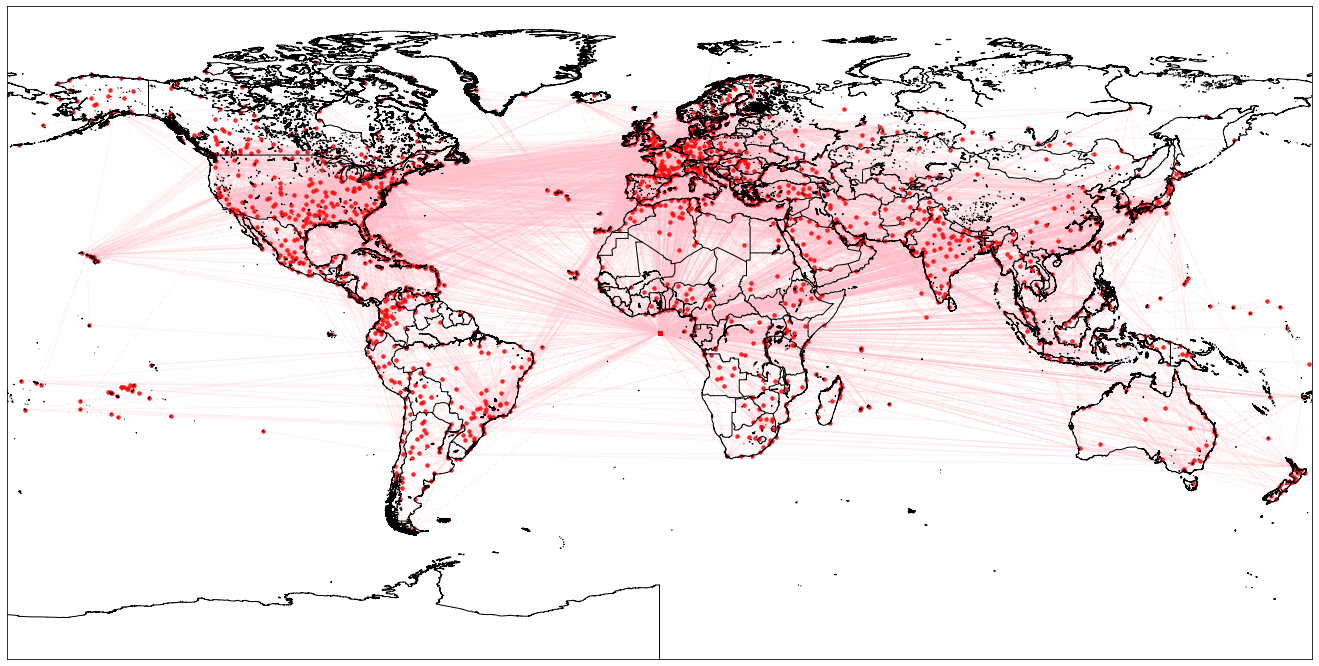

In [20]:
nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(), node_color='red', alpha=0.8, node_size=12)
nx.draw_networkx_edges(G=graph, pos=pos, edge_color='pink', alpha=0.2)
m.drawcountries(linewidth=1)
m.drawcoastlines(linewidth=1)
# plt.tight_layout()
plt.show()

## Get connected components (remove isolated nodes)

Got these 24 nodes:
['AWD', 'FTA', 'AXR', 'KKR', 'RFP', 'MAU', 'XMH', 'RGI', 'BOB', 'TIH', 'MVT', 'HUH', 'FAV', 'MOZ', 'MKP', 'HOI', 'GMR', 'NHV', 'UAP', 'UAH', 'TUB', 'RUR','TKP', 'TKX']

Added them to the initial isolated nodes and removed them from the dataset.

From this point, the graph is fully connected and running this cells will give an error

In [27]:
connected_components = [c for c in sorted(nx.connected_components(graph), reverse=True)]

In [43]:
for lista in connected_components:
    print(lista)

{'BTH', 'ZSA', 'YNA', 'BPN', 'PDV', 'YIO', 'BBI', 'CZE', 'TRC', 'GMB', 'PIS', 'JSH', 'JKH', 'MSW', 'SHB', 'YPY', 'MEM', 'LYA', 'LGA', 'YGJ', 'SAF', 'WMN', 'BLV', 'GRK', 'HKD', 'DLY', 'YHM', 'TAO', 'FSC', 'MYR', 'SFT', 'DMM', 'GPI', 'MHH', 'KMI', 'LFR', 'RGL', 'FMO', 'FMA', 'BQK', 'CGO', 'LCE', 'PNI', 'BMU', 'MRD', 'YHK', 'AMQ', 'AOJ', 'AIU', 'ABI', 'WAT', 'CMH', 'MCX', 'XMS', 'KSF', 'BHD', 'KUS', 'EIS', 'YZT', 'YYQ', 'MSQ', 'PZU', 'PDS', 'HBA', 'BLQ', 'WMR', 'KYZ', 'COS', 'MXP', 'MLA', 'TGR', 'STM', 'AAY', 'ROP', 'IXZ', 'OSL', 'OMS', 'SKN', 'ALF', 'KGA', 'HOG', 'AOR', 'ULB', 'KNX', 'LBJ', 'IPA', 'LYB', 'NYO', 'BUN', 'DNZ', 'TRF', 'BIM', 'LMP', 'PMC', 'OSY', 'ELS', 'ROW', 'DUR', 'FDF', 'HOR', 'KOK', 'KOJ', 'AHB', 'GDX', 'GIB', 'KIS', 'MCM', 'YPR', 'LLW', 'ACY', 'XQP', 'JNU', 'DFW', 'VLN', 'SLU', 'MNL', 'TTU', 'LIH', 'CIA', 'BOO', 'CDG', 'AXM', 'MXX', 'JGA', 'BME', 'YBL', 'XFW', 'GRX', 'TSV', 'PNS', 'LUD', 'TIA', 'ISG', 'YMO', 'NLA', 'PNL', 'TIR', 'AGA', 'NOU', 'NQY', 'LOK', 'ILY', 'BHI'

In [47]:
count = 0
for lista in connected_components[1:]:
    for value in lista:
        if value in connected_components[0]:
           print(True)
        else:
             count +=1
print(count)

24


In [49]:
isolated_components = []
for lista in connected_components[1:]:
    for value in lista:
        isolated_components.append(value)
isolated_components

['AWD',
 'FTA',
 'AXR',
 'KKR',
 'RFP',
 'MAU',
 'XMH',
 'RGI',
 'BOB',
 'TIH',
 'MVT',
 'HUH',
 'FAV',
 'MOZ',
 'MKP',
 'HOI',
 'GMR',
 'NHV',
 'UAP',
 'UAH',
 'TUB',
 'RUR',
 'TKP',
 'TKX']